<div style="background-color: #0000ff; color: #e6f7ff; padding: 20px; border-radius: 10px; text-align: center;">
  <h2>Yelp Review Sentiment Analysis</h2>
</div>






<div style="background-color:  #3366ff; color: #e6f7ff; padding: 20px; border-radius: 10px;">
  <h2>1. Importing Necessary Libraries</h2>
</div>




In [2]:
!pip install nltk
!pip install twython
!pip install textblob
!pip install wordcloud

In [3]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

/Users/nazira/miniconda3/envs/metrica/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
!pip install pandas --upgrade

<div style="background-color:  #3366ff; color: #e6f7ff; padding: 20px; border-radius: 10px;">
  <h2>2. Data Overview</h2>
</div>



In [5]:
yelp_json = pd.read_json('yelp_training_set_review.json',lines = True)
yelp_json.head()

,votes,user_id,review_id,stars,date,text,type,business_id
0,"{'funny': 0, 'useful': 5, 'cool': 2}",rLtl8ZkDX5vH5nAx9C3q5Q,fWKvX83p0-ka4JS3dc6E5A,5,2011-01-26,My wife took me here on my birthday for breakf...,review,9yKzy9PApeiPPOUJEtnvkg
1,"{'funny': 0, 'useful': 0, 'cool': 0}",0a2KyEL0d3Yb1V6aivbIuQ,IjZ33sJrzXqU-0X6U8NwyA,5,2011-07-27,I have no idea why some people give bad review...,review,ZRJwVLyzEJq1VAihDhYiow
2,"{'funny': 0, 'useful': 1, 'cool': 0}",0hT2KtfLiobPvh6cDC8JQg,IESLBzqUCLdSzSqm0eCSxQ,4,2012-06-14,love the gyro plate. Rice is so good and I als...,review,6oRAC4uyJCsJl1X0WZpVSA
3,"{'funny': 0, 'useful': 2, 'cool': 1}",uZetl9T0NcROGOyFfughhg,G-WvGaISbqqaMHlNnByodA,5,2010-05-27,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,_1QQZuf4zZOyFCvXc0o6Vg
4,"{'funny': 0, 'useful': 0, 'cool': 0}",vYmM4KTsC8ZfQBg-j5MWkw,1uJFq2r5QfJG_6ExMRCaGw,5,2012-01-05,General Manager Scott Petello is a good egg!!!...,review,6ozycU1RpktNG2-1BroVtw


Which is the business got the most 1-star reviews?

In [6]:
one_star_reviews = yelp_json.query(' stars == 1 ')

In [7]:
one_star_reviews['business_id'].value_counts()

business_id
bA-Cj6N9TEMlDlOh2aAnUw    95
hW0Ne_HTHEAgGF1rAdmR-g    54
VVeogjZya58oiTxK7qUjAQ    47
K845ZDttFfx99zQ-0aE2tA    39
fF6m3qsD5blnwuZRuYhzWg    35
                          ..
JXBdcBb3ivm89fhr6-yfSQ     1
cRwNwAGQ8Pc_-orLefrwRw     1
IpP2njkj92uTWAKToRmg1g     1
X-L8U0Kjsb6ey4gNf6fyLQ     1
HNusESyB6lEgrf5IUwUr_g     1
Name: count, Length: 6292, dtype: int64

In [8]:
votes_new = pd.json_normalize(yelp_json['votes'])
votes_new

,funny,useful,cool
0,0,5,2
1,0,0,0
2,0,1,0
3,0,2,1
4,0,0,0
...,...,...,...
229902,0,0,0
229903,0,2,0
229904,0,0,0
229905,1,2,0


In [9]:
yelp_orig = pd.concat([yelp_json,votes_new], axis=1).drop(columns=['votes'])
yelp_orig.head()

,user_id,review_id,stars,date,text,type,business_id,funny,useful,cool
0,rLtl8ZkDX5vH5nAx9C3q5Q,fWKvX83p0-ka4JS3dc6E5A,5,2011-01-26,My wife took me here on my birthday for breakf...,review,9yKzy9PApeiPPOUJEtnvkg,0,5,2
1,0a2KyEL0d3Yb1V6aivbIuQ,IjZ33sJrzXqU-0X6U8NwyA,5,2011-07-27,I have no idea why some people give bad review...,review,ZRJwVLyzEJq1VAihDhYiow,0,0,0
2,0hT2KtfLiobPvh6cDC8JQg,IESLBzqUCLdSzSqm0eCSxQ,4,2012-06-14,love the gyro plate. Rice is so good and I als...,review,6oRAC4uyJCsJl1X0WZpVSA,0,1,0
3,uZetl9T0NcROGOyFfughhg,G-WvGaISbqqaMHlNnByodA,5,2010-05-27,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,_1QQZuf4zZOyFCvXc0o6Vg,0,2,1
4,vYmM4KTsC8ZfQBg-j5MWkw,1uJFq2r5QfJG_6ExMRCaGw,5,2012-01-05,General Manager Scott Petello is a good egg!!!...,review,6ozycU1RpktNG2-1BroVtw,0,0,0


<div style="background-color:  #3366ff; color: #e6f7ff; padding: 20px; border-radius: 10px;">
  <h2>3. Text Preprocessing</h2>
</div>




## 3.1 Normalizing Case Folding ##

In [10]:
yelp_orig['text']

0         My wife took me here on my birthday for breakf...
1         I have no idea why some people give bad review...
2         love the gyro plate. Rice is so good and I als...
3         Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
4         General Manager Scott Petello is a good egg!!!...
                                ...                        
229902    I really wanted to like this place because it'...
229903    My husband I stayed here for two nights.  Of c...
229904    Cool atmosphere. A lot of beers on tap and goo...
229905    I have to take a star off for the spotty servi...
229906                                         So cool, yo.
Name: text, Length: 229907, dtype: object

In [11]:
yelp_orig['text'] = yelp_orig['text'].str.lower()

In [12]:
yelp_orig['text']

0         my wife took me here on my birthday for breakf...
1         i have no idea why some people give bad review...
2         love the gyro plate. rice is so good and i als...
3         rosie, dakota, and i love chaparral dog park!!...
4         general manager scott petello is a good egg!!!...
                                ...                        
229902    i really wanted to like this place because it'...
229903    my husband i stayed here for two nights.  of c...
229904    cool atmosphere. a lot of beers on tap and goo...
229905    i have to take a star off for the spotty servi...
229906                                         so cool, yo.
Name: text, Length: 229907, dtype: object

## 3.2 Remove Punctuations ##

In [13]:
yelp_orig['text'] = yelp_orig['text'].str.replace('[^\w\s]', '', regex=True)

In [14]:
yelp_orig['text']

0         my wife took me here on my birthday for breakf...
1         i have no idea why some people give bad review...
2         love the gyro plate rice is so good and i also...
3         rosie dakota and i love chaparral dog park its...
4         general manager scott petello is a good egg no...
                                ...                        
229902    i really wanted to like this place because its...
229903    my husband i stayed here for two nights  of co...
229904    cool atmosphere a lot of beers on tap and good...
229905    i have to take a star off for the spotty servi...
229906                                           so cool yo
Name: text, Length: 229907, dtype: object

In [15]:
yelp_orig['text'] = yelp_orig['text'].str.replace('\d', '', regex=True)

## 3.3 Remove Stopwords ##

In [16]:
sw = stopwords.words('english')

In [17]:
yelp_orig['text'] = yelp_orig['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [18]:
yelp_orig['text']

0         wife took birthday breakfast excellent weather...
1         idea people give bad reviews place goes show p...
2         love gyro plate rice good also dig candy selec...
3         rosie dakota love chaparral dog park convenien...
4         general manager scott petello good egg go deta...
                                ...                        
229902    really wanted like place close home honestly b...
229903    husband stayed two nights course room wasnt re...
229904    cool atmosphere lot beers tap good food went s...
229905    take star spotty service received last time lu...
229906                                              cool yo
Name: text, Length: 229907, dtype: object

## 3.4 Remove Rarewords ##

In [19]:
temp_df = pd.Series(' '.join(yelp_orig['text']).split()).value_counts()

In [20]:
temp_df

good                                152339
place                               150376
food                                139493
great                               114933
like                                114697
                                     ...  
flambrulee                               1
predevoured                              1
khanith                                  1
greatneeded                              1
forcedfriendlybutreallyirritated         1
Name: count, Length: 214563, dtype: int64

In [21]:
drops = temp_df[temp_df <= 1]

In [22]:
yelp_orig['text'] = yelp_orig['text'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [23]:
yelp_orig['text']

0         wife took birthday breakfast excellent weather...
1         idea people give bad reviews place goes show p...
2         love gyro plate rice good also dig candy selec...
3         rosie dakota love chaparral dog park convenien...
4         general manager scott good egg go detail let a...
                                ...                        
229902    really wanted like place close home honestly b...
229903    husband stayed two nights course room wasnt re...
229904    cool atmosphere lot beers tap good food went s...
229905    take star spotty service received last time lu...
229906                                              cool yo
Name: text, Length: 229907, dtype: object

In [24]:
temp_df_1 = pd.Series(' '.join(yelp_orig['text']).split()).value_counts()

In [25]:
temp_df_1

good               152339
place              150376
food               139493
great              114933
like               114697
                    ...  
tiptoes                 2
invergorden             2
doormansecurity         2
waitressand             2
cullinary               2
Name: count, Length: 80774, dtype: int64

## 3.5 Tokenization ##

In [26]:
import nltk
nltk.download('punkt')

yelp_orig['text'].apply(lambda x: TextBlob(x).words).head()

[nltk_data] Downloading package punkt to /Users/nazira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    [wife, took, birthday, breakfast, excellent, w...
1    [idea, people, give, bad, reviews, place, goes...
2    [love, gyro, plate, rice, good, also, dig, can...
3    [rosie, dakota, love, chaparral, dog, park, co...
4    [general, manager, scott, good, egg, go, detai...
Name: text, dtype: object

## 3.6 Lemmatization ##

In [27]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/nazira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/nazira/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [29]:
yelp_orig['text'] = yelp_orig['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [30]:
yelp_orig['text']

0         wife took birthday breakfast excellent weather...
1         idea people give bad review place go show plea...
2         love gyro plate rice good also dig candy selec...
3         rosie dakota love chaparral dog park convenien...
4         general manager scott good egg go detail let a...
                                ...                        
229902    really wanted like place close home honestly b...
229903    husband stayed two night course room wasnt rea...
229904    cool atmosphere lot beer tap good food went sa...
229905    take star spotty service received last time lu...
229906                                              cool yo
Name: text, Length: 229907, dtype: object

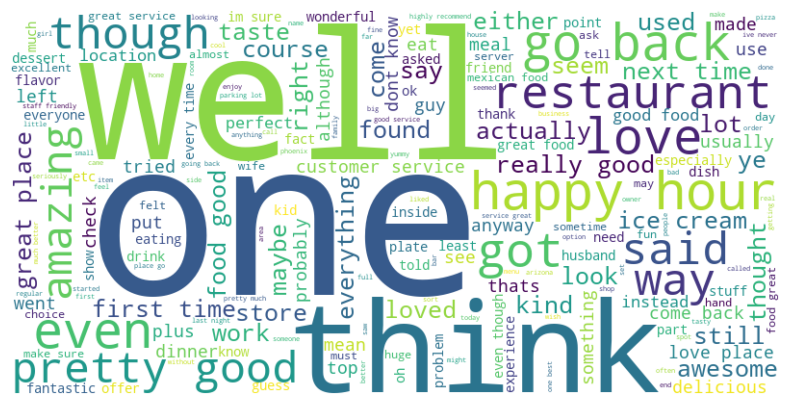

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the processed text into one string
text = ' '.join(yelp_orig['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 3.7 Calculation of Term Frequencies ##

In [42]:
# Filter out empty processed texts
yelp_orig = yelp_orig[yelp_orig['text'] != '']

In [44]:
documents = yelp_orig['text'].tolist()
documents = [doc for doc in documents if doc.strip() != '']

In [45]:
# Debugging: Print the first few documents
print("First few documents after preprocessing:")
for doc in documents[:5]:
    print(doc)

First few documents after preprocessing:
wife took birthday breakfast excellent weather perfect made sitting outside overlooking ground absolute pleasure waitress excellent food arrived quickly semibusy saturday morning looked like place fill pretty quickly earlier get better favor get bloody mary phenomenal simply best ive ever im pretty sure use ingredient garden blend fresh order amazing everything menu look excellent white truffle scrambled egg vegetable skillet tasty delicious came piece griddled bread amazing absolutely made meal complete best toast ive ever anyway cant wait go back
idea people give bad review place go show please everyone probably griping something many people like case friend arrived pm past sunday pretty crowded thought sunday evening thought would wait forever get seat said well seated girl come back seating someone else seated waiter came got drink order everyone pleasant host seated u waiter server price good well placed order decided wanted shared baked sp

In [46]:
# Check the length of documents to ensure no empty strings
print(f"Total number of documents: {len(documents)}")

Total number of documents: 229880


In [47]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, max_features=10000)
X = vectorizer.fit_transform(documents)

In [48]:
feature_names = vectorizer.get_feature_names_out()

In [49]:
# Calculate term frequencies from TF-IDF matrix X
term_frequencies = np.asarray(X.sum(axis=0)).reshape(-1)

In [51]:
# Create a DataFrame for term frequencies
tf = pd.DataFrame({'term': feature_names, 'frequency': term_frequencies})

# Sort terms by frequency
tf = tf.sort_values(by='frequency', ascending=False).reset_index(drop=True)

# Print or further analyze 'tf' DataFrame
tf.head(20)

,term,frequency
0,place,7812.069734
1,good,7597.962532
2,food,7553.172953
3,great,7193.917729
4,like,5216.615299
5,time,5138.182117
6,service,4929.993934
7,get,4736.035549
8,one,4611.213087
9,go,4533.892097


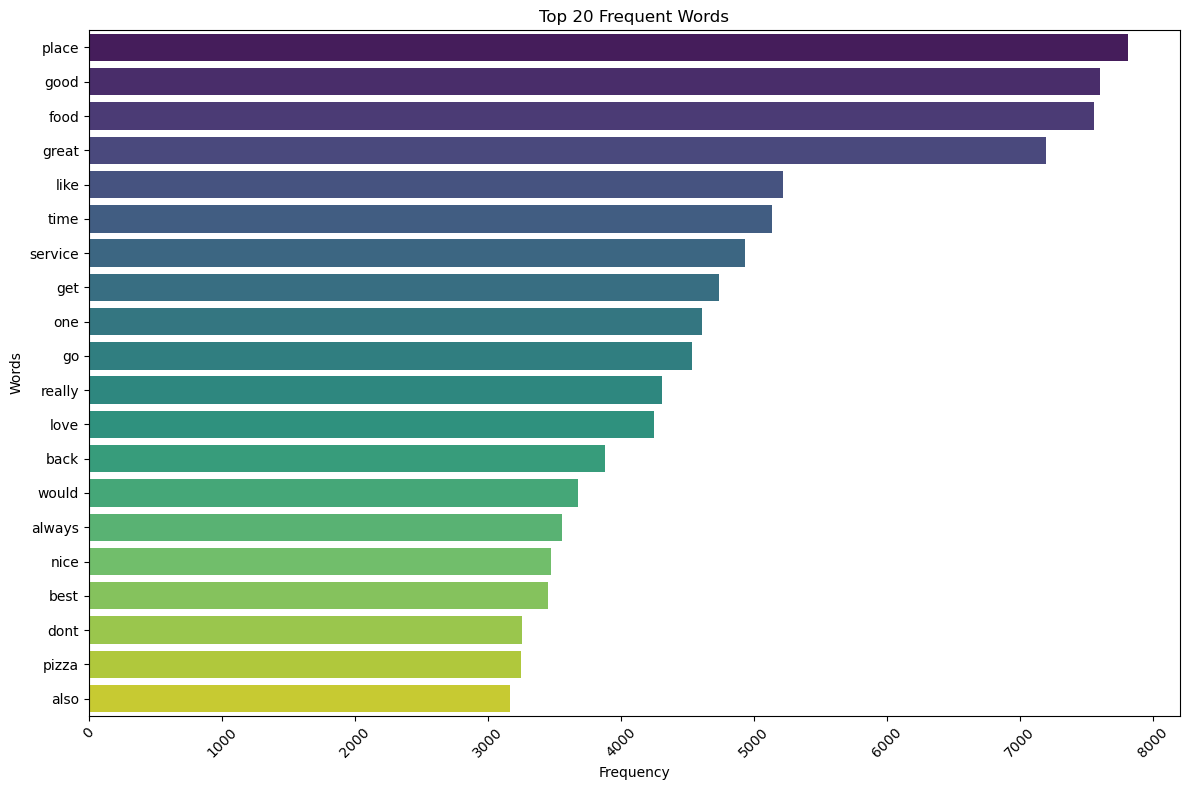

In [57]:
top_words = tf.head(20)

# Initialize the plot
plt.figure(figsize=(12, 8))

# Create a bar plot using Seaborn
sns.barplot(x='frequency', y='term', data=top_words, palette='viridis')

# Customize the plot
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Frequent Words')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the plot
plt.tight_layout()
plt.show()

<div style="background-color:  #3366ff; color: #e6f7ff; padding: 20px; border-radius: 10px;">
  <h2>4. Sentiment Analysis </h2>
</div>


In [59]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nazira/nltk_data...


True

In [60]:
yelp_orig["text"].head()

0    wife took birthday breakfast excellent weather...
1    idea people give bad review place go show plea...
2    love gyro plate rice good also dig candy selec...
3    rosie dakota love chaparral dog park convenien...
4    general manager scott good egg go detail let a...
Name: text, dtype: object

In [61]:
sia = SentimentIntensityAnalyzer()

In [62]:
sia.polarity_scores("The food was delicious, but the service was not nice.")

{'neg': 0.225, 'neu': 0.599, 'pos': 0.176, 'compound': -0.165}

In [67]:
sia.polarity_scores("It was great to be there.")

{'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'compound': 0.6249}

In [69]:
yelp_orig["text"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])


0    0.9950
1    0.9901
2    0.7964
3    0.9360
4    0.9561
5    0.9903
6    0.9931
7    0.9517
8    0.9643
9    0.6124
Name: text, dtype: float64

In [70]:
yelp_orig["polarity_score"] =yelp_orig["text"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [71]:
yelp_orig.head(20)

,user_id,review_id,stars,date,text,type,business_id,funny,useful,cool,polarity_score
0,rLtl8ZkDX5vH5nAx9C3q5Q,fWKvX83p0-ka4JS3dc6E5A,5,2011-01-26,wife took birthday breakfast excellent weather...,review,9yKzy9PApeiPPOUJEtnvkg,0,5,2,0.9950
1,0a2KyEL0d3Yb1V6aivbIuQ,IjZ33sJrzXqU-0X6U8NwyA,5,2011-07-27,idea people give bad review place go show plea...,review,ZRJwVLyzEJq1VAihDhYiow,0,0,0,0.9901
2,0hT2KtfLiobPvh6cDC8JQg,IESLBzqUCLdSzSqm0eCSxQ,4,2012-06-14,love gyro plate rice good also dig candy selec...,review,6oRAC4uyJCsJl1X0WZpVSA,0,1,0,0.7964
3,uZetl9T0NcROGOyFfughhg,G-WvGaISbqqaMHlNnByodA,5,2010-05-27,rosie dakota love chaparral dog park convenien...,review,_1QQZuf4zZOyFCvXc0o6Vg,0,2,1,0.9360
4,vYmM4KTsC8ZfQBg-j5MWkw,1uJFq2r5QfJG_6ExMRCaGw,5,2012-01-05,general manager scott good egg go detail let a...,review,6ozycU1RpktNG2-1BroVtw,0,0,0,0.9561
5,sqYN3lNgvPbPCTRsMFu27g,m2CKSsepBCoRYWxiRUsxAg,4,2007-12-13,quiessence simply put beautiful full window ea...,review,-yxfBYGB6SEqszmxJxd97A,1,3,4,0.9903
6,wFweIWhv2fREZV_dYkz_1g,riFQ3vxNpP4rWLk_CSri2A,5,2010-02-12,drop youre drive ate go back next day food goo...,review,zp713qNhx8d9KCJJnrw1xA,4,7,7,0.9931
7,1ieuYcKS7zeAv_U15AB13A,JL7GXJ9u4YMx7Rzs05NfiQ,4,2012-07-12,luckily didnt travel far make connecting fligh...,review,hW0Ne_HTHEAgGF1rAdmR-g,0,1,0,0.9517
8,Vh_DlizgGhSqQh4qfZ2h6A,XtnfnYmnJYi71yIuGsXIUA,4,2012-08-17,definitely come happy hour price amazing sake ...,review,wNUea3IXZWD63bbOQaOH-g,0,0,0,0.9643
9,sUNkXg8-KFtCMQDV6zRzQg,jJAIXA46pU1swYyRCdfXtQ,5,2010-08-11,nobuo show unique talent everything menu caref...,review,nMHhuYan8e3cONo3PornJA,0,1,0,0.6124


## 4.1 Feature Engineering ##

**In this section, we perform sentiment analysis to assess the emotional sentiment conveyed in the texts. Each comment is categorized as either 'positive' (pos) or 'negative' (neg) based on its compound sentiment score. We then analyze how these sentiment labels are distributed throughout the dataset and their correlation with overall rating scores. To facilitate subsequent analysis and modeling, we convert these sentiment labels into numerical values. These steps are crucial for extracting valuable features from our text data, ensuring it is well-prepared for advanced analytical and modeling tasks.**

In [72]:
yelp_orig["text"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

0    pos
1    pos
2    pos
3    pos
4    pos
5    pos
6    pos
7    pos
8    pos
9    pos
Name: text, dtype: object

In [78]:
yelp_orig["sentiment_label"] = yelp_orig["text"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")


In [80]:
yelp_orig.head()

,user_id,review_id,stars,date,text,type,business_id,funny,useful,cool,polarity_score,sentiment_label
0,rLtl8ZkDX5vH5nAx9C3q5Q,fWKvX83p0-ka4JS3dc6E5A,5,2011-01-26,wife took birthday breakfast excellent weather...,review,9yKzy9PApeiPPOUJEtnvkg,0,5,2,0.9950,pos
1,0a2KyEL0d3Yb1V6aivbIuQ,IjZ33sJrzXqU-0X6U8NwyA,5,2011-07-27,idea people give bad review place go show plea...,review,ZRJwVLyzEJq1VAihDhYiow,0,0,0,0.9901,pos
2,0hT2KtfLiobPvh6cDC8JQg,IESLBzqUCLdSzSqm0eCSxQ,4,2012-06-14,love gyro plate rice good also dig candy selec...,review,6oRAC4uyJCsJl1X0WZpVSA,0,1,0,0.7964,pos
3,uZetl9T0NcROGOyFfughhg,G-WvGaISbqqaMHlNnByodA,5,2010-05-27,rosie dakota love chaparral dog park convenien...,review,_1QQZuf4zZOyFCvXc0o6Vg,0,2,1,0.9360,pos
4,vYmM4KTsC8ZfQBg-j5MWkw,1uJFq2r5QfJG_6ExMRCaGw,5,2012-01-05,general manager scott good egg go detail let a...,review,6ozycU1RpktNG2-1BroVtw,0,0,0,0.9561,pos


In [81]:
yelp_orig["sentiment_label"].value_counts()

sentiment_label
pos    210381
neg     19499
Name: count, dtype: int64

In [83]:
yelp_orig["sentiment_label"] = LabelEncoder().fit_transform(yelp_orig["sentiment_label"])

In [84]:
yelp_orig.head()

,user_id,review_id,stars,date,text,type,business_id,funny,useful,cool,polarity_score,sentiment_label
0,rLtl8ZkDX5vH5nAx9C3q5Q,fWKvX83p0-ka4JS3dc6E5A,5,2011-01-26,wife took birthday breakfast excellent weather...,review,9yKzy9PApeiPPOUJEtnvkg,0,5,2,0.9950,1
1,0a2KyEL0d3Yb1V6aivbIuQ,IjZ33sJrzXqU-0X6U8NwyA,5,2011-07-27,idea people give bad review place go show plea...,review,ZRJwVLyzEJq1VAihDhYiow,0,0,0,0.9901,1
2,0hT2KtfLiobPvh6cDC8JQg,IESLBzqUCLdSzSqm0eCSxQ,4,2012-06-14,love gyro plate rice good also dig candy selec...,review,6oRAC4uyJCsJl1X0WZpVSA,0,1,0,0.7964,1
3,uZetl9T0NcROGOyFfughhg,G-WvGaISbqqaMHlNnByodA,5,2010-05-27,rosie dakota love chaparral dog park convenien...,review,_1QQZuf4zZOyFCvXc0o6Vg,0,2,1,0.9360,1
4,vYmM4KTsC8ZfQBg-j5MWkw,1uJFq2r5QfJG_6ExMRCaGw,5,2012-01-05,general manager scott good egg go detail let a...,review,6ozycU1RpktNG2-1BroVtw,0,0,0,0.9561,1


## 4.2 Count Vectors ##

**In this section, we employ the CountVectorizer method to convert the textual content from the 'reviewText' column into numerical vectors. This transformation involves calculating the frequency of each word across the texts, which is then used to create a numerical representation for each text. This step is essential as it prepares the text data for integration into machine learning models. By converting texts into numerical formats, we streamline the extraction of significant features and optimize data processing during subsequent modeling phases. This approach ensures that our models can efficiently analyze and interpret textual data to derive meaningful insights.**

In [94]:
yelp_orig['text']

0         wife took birthday breakfast excellent weather...
1         idea people give bad review place go show plea...
2         love gyro plate rice good also dig candy selec...
3         rosie dakota love chaparral dog park convenien...
4         general manager scott good egg go detail let a...
                                ...                        
229902    really wanted like place close home honestly b...
229903    husband stayed two night course room wasnt rea...
229904    cool atmosphere lot beer tap good food went sa...
229905    take star spotty service received last time lu...
229906                                              cool yo
Name: text, Length: 229880, dtype: object

In [111]:
from sklearn.feature_extraction.text import CountVectorizer


In [117]:
import string
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()


# Example function for text preprocessing
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing to your text data
processed_text = yelp_orig['text'].apply(preprocess_text)


In [118]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with desired parameters
vectorizer = CountVectorizer(max_features=1000)  

# Fit and transform the vectorizer on your preprocessed text data
X = vectorizer.fit_transform(processed_text)


feature_names = vectorizer.get_feature_names_out()


In [119]:
# Create a DataFrame to explore the vectorized data
vectorized_df = pd.DataFrame(X.toarray(), columns=feature_names)

# Display the vectorized DataFrame
print(vectorized_df.head())

   able  absolutely  across  actually  add  added  addition  afternoon  ago  \
0     0           1       0         0    0      0         0          0    0   
1     0           0       0         0    0      0         0          0    0   
2     0           0       0         0    0      0         0          0    0   
3     0           0       0         0    0      0         0          0    0   
4     0           0       0         0    0      0         0          0    0   

   ahead  ...  yelp  yes  yet  yogurt  youll  young  youre  youve  yum  yummy  
0      0  ...     0    0    0       0      0      0      0      0    0      0  
1      0  ...     0    0    0       0      0      0      0      0    0      0  
2      0  ...     0    0    0       0      0      0      0      0    0      0  
3      0  ...     0    0    0       0      0      0      0      0    0      0  
4      0  ...     0    0    0       0      0      0      0      1    0      0  

[5 rows x 1000 columns]


## 4.3 TF_IDF Vectors ##

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer


texts = yelp_orig['text']


tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on your data
X_tf_idf_word = tfidf_vectorizer.fit_transform(texts)




In [128]:
y = yelp_orig["sentiment_label"] 

## 4.4 Train Logistic Regression Model ##

In [137]:

log_model = LogisticRegression().fit(X_tf_idf_word, y)

In [138]:
cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()

0.9482860622933703

In [139]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the logistic regression model 
log_model = LogisticRegression().fit(X_tf_idf_word, y)

# Example new reviews
new_reviews = [
    "This restaurant was amazing, I loved the food!",
    "Terrible experience, wouldn't recommend it to anyone."
]

# Apply preprocessing to new reviews
processed_reviews = [preprocess_text(review) for review in new_reviews]


X_new = tfidf_vectorizer.transform(processed_reviews)

# Make predictions with the trained logistic regression model
predictions = log_model.predict(X_new)

# Interpret the predictions
for review, prediction in zip(new_reviews, predictions):
    sentiment = 'Positive' if prediction == 1 else 'Negative'
    print(f"Review: {review} -> Predicted Sentiment: {sentiment}")




Review: This restaurant was amazing, I loved the food! -> Predicted Sentiment: Positive
Review: Terrible experience, wouldn't recommend it to anyone. -> Predicted Sentiment: Negative


**Based on our analysis and modeling, we achieved a cross-validation accuracy of 95% with our logistic regression model. This high accuracy indicates that our preprocessing steps, including text cleaning, tokenization, and TF-IDF vectorization, effectively prepared the text data for sentiment analysis. Our logistic regression model successfully captured the underlying patterns in the data, enabling it to predict sentiment with high accuracy. This project demonstrates the effectiveness of combining thorough data preprocessing with a robust machine learning algorithm to analyze and classify text data.**